In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf

alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype');

### Read Data

In [2]:
with open("config.yaml", "r") as config_file:
    config = yaml.full_load(config_file)
    data_path = config["data_path"]

In [3]:
price_rank_df = pd.read_csv(os.path.join(data_path, "price_rank_data.csv"))
price_rank_df.head(3)

,price,rank
0,2,7493.00000
1,3,45263.00000
2,4,40212.49505


In [4]:
sales_df = pd.read_csv(os.path.join(data_path, "preprocessed_data.csv"))
sales_df["dt"] = pd.to_datetime(sales_df["dt"])
print(f"Number of samples: {sales_df.shape[0]}")
sales_df.head(3)

Number of samples: 1058


,dt,inventory,units,adspend,rank
0,2017-09-26,693,36,83.79,51432
1,2017-09-27,673,34,67.16,48596
2,2017-09-28,626,33,50.49,43191


In [5]:
all_sales_df = pd.read_csv(os.path.join(data_path, "pure_sales_data.csv")).rename(columns={"value": "units"})
all_sales_df["dt"] = pd.to_datetime(all_sales_df["dt"])
all_sales_df.head(3)

,dt,units
0,2015-04-01,0.0
1,2015-04-02,0.0
2,2015-04-03,0.0


### Price-Rank

In [6]:
min_price, max_price = price_rank_df["price"].min(), price_rank_df["price"].max()
print(f"Min price: {min_price}\nMax price: {max_price}")

Min price: 2
Max price: 49


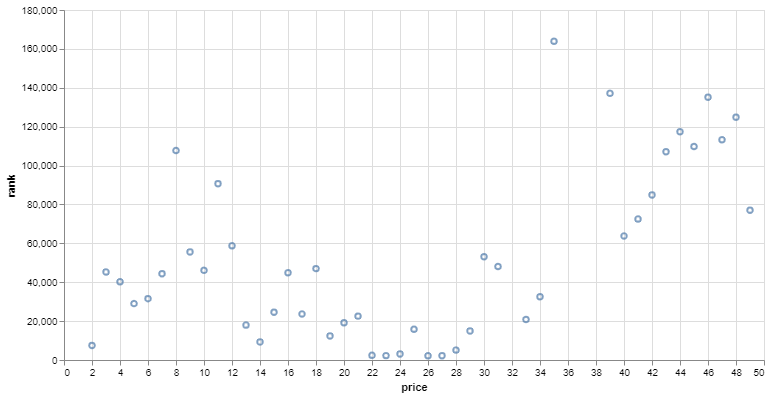

In [7]:
alt.Chart(price_rank_df).mark_point().encode(
    x=alt.X('price:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('rank:Q', scale=alt.Scale(zero=False))
).properties(width=700, height=350)

### Sales Data

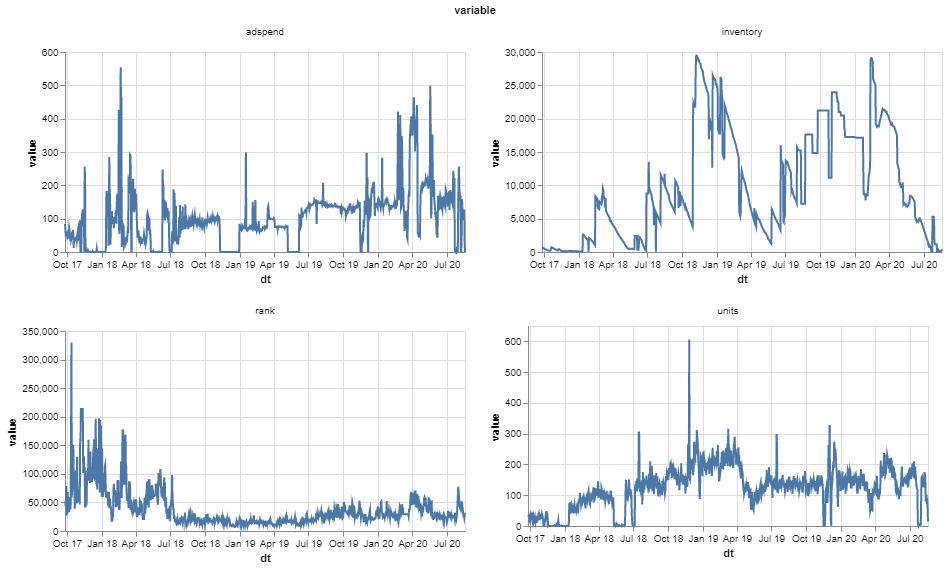

In [8]:
alt.Chart(pd.melt(sales_df, "dt")).mark_line() \
.encode(
    x = alt.X("dt:T", axis=alt.Axis(format="%b %y")),
    y = alt.Y("value:Q")
).properties(width=800 / 2, height=800 / 4) \
.facet(
    facet=alt.Facet("variable:N"),
    columns=2
).resolve_scale(y="independent", x="independent")

### Seasonality

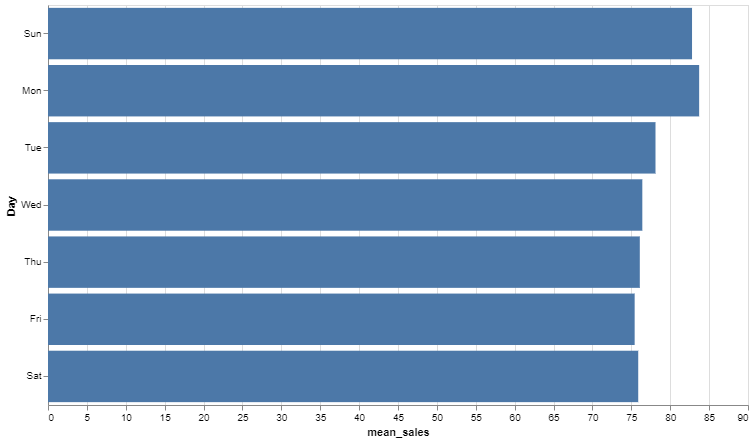

In [9]:
alt.Chart(all_sales_df).mark_bar() \
.transform_timeunit(day="day(dt)") \
.transform_aggregate(groupby=["day"], mean_sales="mean(units)") \
.encode(
    y = alt.Y("day:O", timeUnit="day", axis=alt.Axis(title="Day")),
    x = alt.X("mean_sales:Q"),
).properties(width=700, height=400)

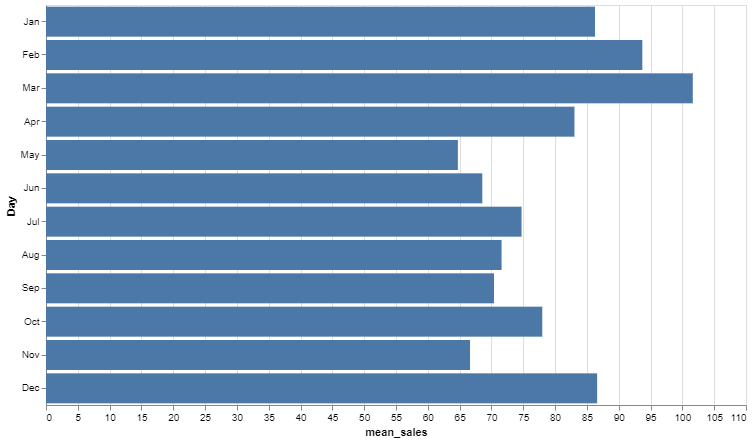

In [10]:
alt.Chart(all_sales_df).mark_bar() \
.transform_timeunit(month="month(dt)") \
.transform_aggregate(groupby=["month"], mean_sales="mean(units)") \
.encode(
    y = alt.Y("month:O", timeUnit="month", axis=alt.Axis(title="Day")),
    x = alt.X("mean_sales:Q"),
).properties(width=700, height=400)

In [11]:
weekly_sales_df = all_sales_df.groupby(pd.Grouper(key="dt", freq="W")).agg({"units": "mean"}).reset_index()
weekly_sales_df.head(3)

,dt,units
0,2015-04-05,0.000000
1,2015-04-12,4.285714
2,2015-04-19,19.571429


C:\Users\andrii.prysiazhnyk\AppData\Local\Continuum\anaconda3\envs\amazon_pricing\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


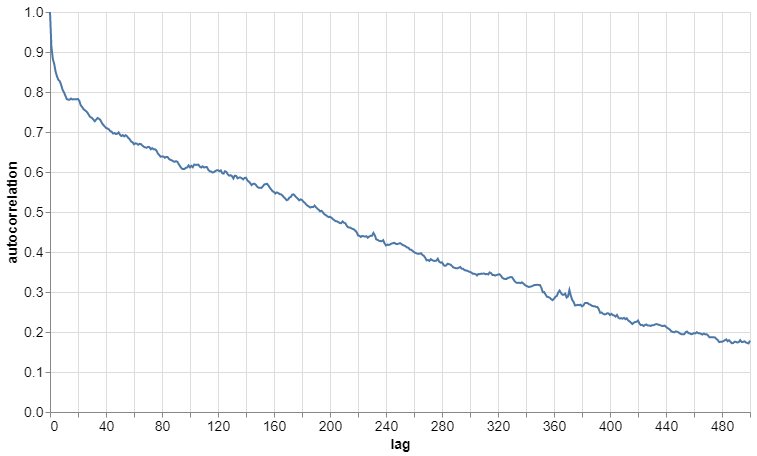

In [38]:
n_lags = 500
autocorrelation = acf(all_sales_df["units"], nlags=n_lags)

autocorrelation_df = pd.DataFrame({"lag": list(range(0, n_lags + 1)), "autocorrelation": autocorrelation})

alt.Chart(autocorrelation_df).mark_line() \
.encode(
    x = alt.X("lag:Q"),
    y = alt.Y("autocorrelation:Q")
).properties(width=700, height=400).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

### Correlation

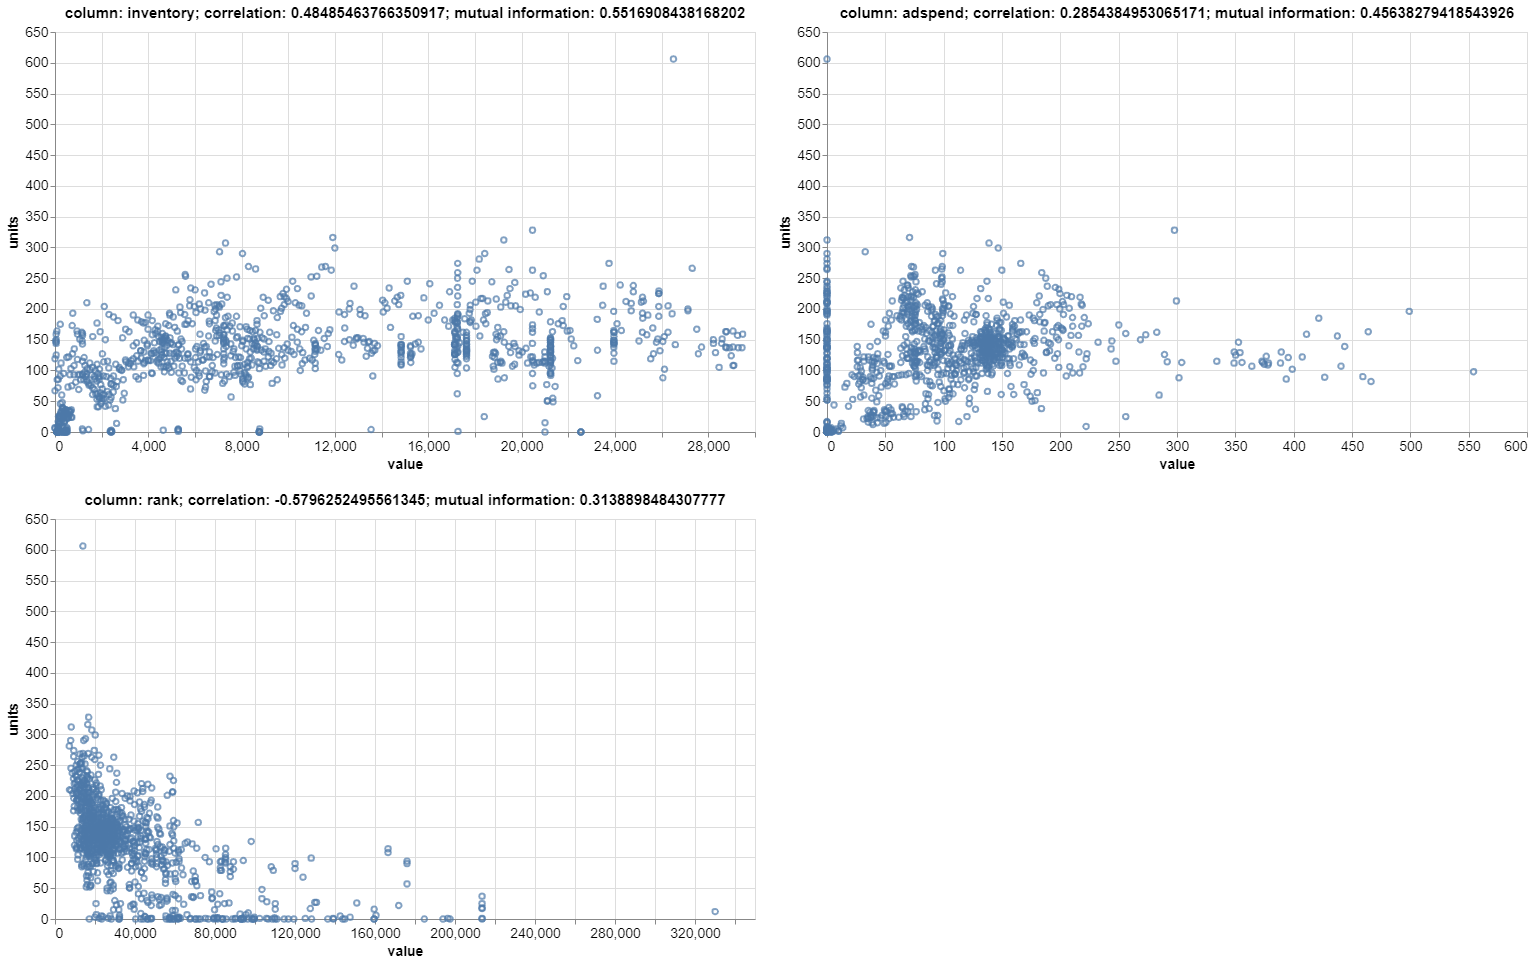

In [14]:
melted_df = pd.melt(sales_df, ["dt", "units"])
independent_columns = ["inventory", "adspend", "rank"]
corr = sales_df.corr()["units"]
mutual_info = mutual_info_regression(sales_df[independent_columns], sales_df["units"])

scatter_plot = alt.Chart(melted_df).mark_point().encode(
    x=alt.X("value:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("units:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      scatter_plot.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=f"column: {name}; correlation: {corr[name]}; mutual information: {mutual_info[i]}", height=400, width=700)
      for i, name in enumerate(independent_columns)
    ],
    columns=2
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="independent",
    y="independent"
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=15)

### Lags correlation

In [15]:
def create_lags_dataset(x, y, n_lags):
    df = pd.DataFrame({"lag0": x})

    for i in range(1, n_lags + 1):
        df[f"lag{i}"] = x.shift(i)

    return df.iloc[n_lags:], y.iloc[n_lags:]

In [16]:
def get_random_forest_importances(x, y):
    model = RandomForestRegressor()
    model.fit(x, y)
    return model.feature_importances_

In [17]:
def get_pacf(x, y):
    columns = x.columns
    pacf = [x[columns[0]].corr(y)]
    
    for i in range(1, len(columns)):
        model = LinearRegression()
        cur_x = x[columns[:i]]
        model.fit(cur_x, y)
        residuals = y - model.predict(cur_x)
        pacf.append(x[columns[i]].corr(residuals))
    
    return np.array(pacf)

In [18]:
def get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, feature_importance_fn):
    lags = list(range(n_lags + 1))
    feature_importances_dict = {"lag": lags}
    
    for column, use_zero_lag in zip(independent_columns, use_zero_lag_list):
        x, y = create_lags_dataset(column, target_column, n_lags)
        if not use_zero_lag:
            x.drop("lag0", axis=1, inplace=True)
        
        feature_importances = feature_importance_fn(x, y)
        if not use_zero_lag:
            feature_importances = np.concatenate((np.array([np.NaN]), feature_importances))
        
        feature_importances_dict[column.name] = feature_importances
    
    return pd.DataFrame(feature_importances_dict)

#### Sales investigation

In [20]:
columns = ["adspend", "rank", "units"]
use_zero_lag_list = [True, True, False]
independent_columns = [sales_df[column] for column in columns]
target_column = sales_df["units"]

In [22]:
n_lags = 100
mutual_info_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, mutual_info_regression)
mutual_info_importances.head(3)

,lag,adspend,rank,units
0,0,0.339245,0.236775,NaN
1,1,0.285464,0.198339,0.840591
2,2,0.233471,0.247731,0.632307


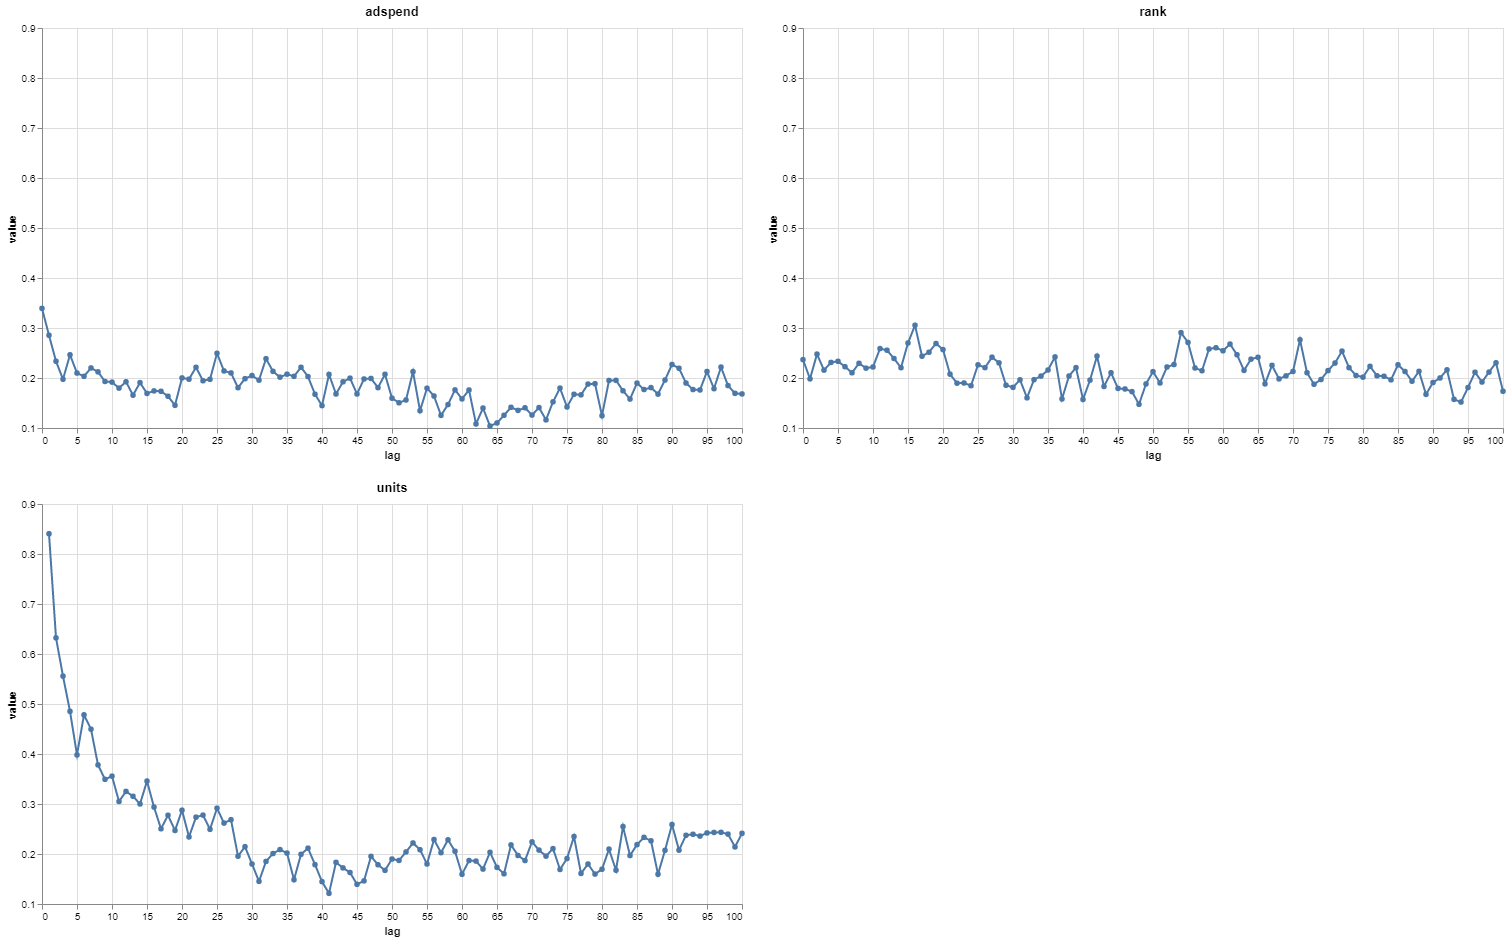

In [24]:
chart = alt.Chart(pd.melt(mutual_info_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=column)) \
                  .properties(title=column, height=400, width=700)
      for column in columns
    ],
    columns=2
).resolve_axis(
    x="shared",
    y="shared"
).resolve_scale(
    x="shared", 
    y="shared"
)

In [25]:
n_lags = 100

random_forest_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, get_random_forest_importances)
random_forest_importances.head(3)

,lag,adspend,rank,units
0,0,0.167703,0.063248,NaN
1,1,0.020639,0.016809,0.745836
2,2,0.007620,0.023144,0.009746


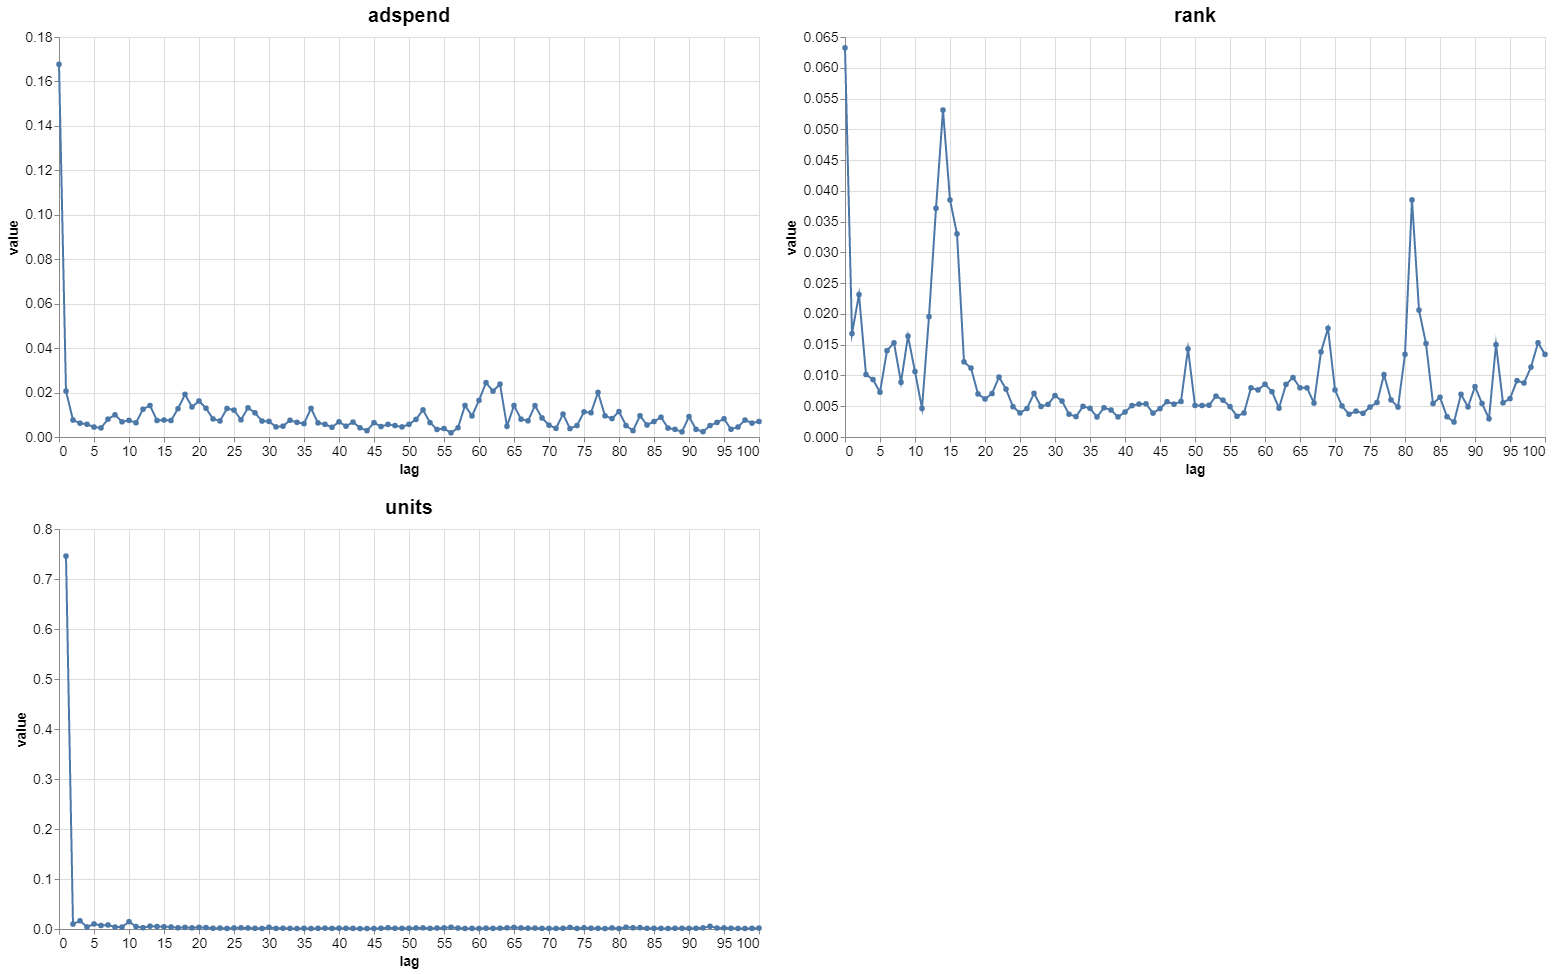

In [27]:
chart = alt.Chart(pd.melt(random_forest_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=name, height=400, width=700)
      for name in columns
    ],
    columns=2
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="independent", 
    y="independent"
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

In [28]:
n_lags = 100
pacf_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, get_pacf)
pacf_importances.head(3)

,lag,adspend,rank,units
0,0,0.170358,-0.473823,NaN
1,1,-0.006378,-0.049373,0.828309
2,2,-0.008496,-0.052204,0.123616


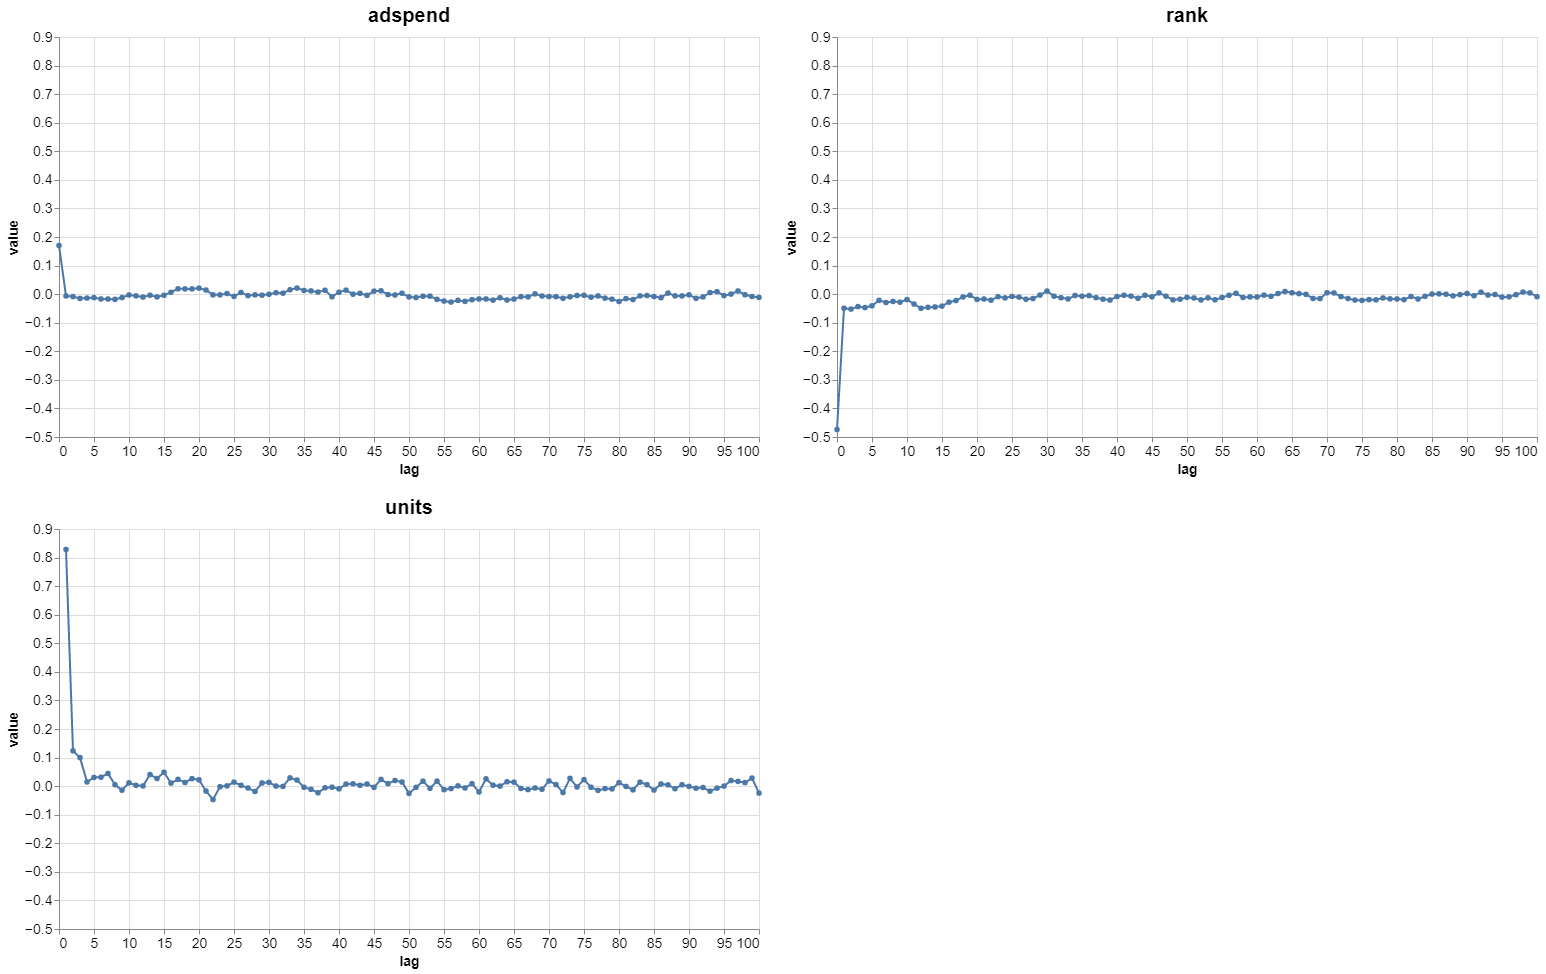

In [30]:
chart = alt.Chart(pd.melt(pacf_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=name, height=400, width=700)
      for name in columns
    ],
    columns=2
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="shared", 
    y="shared"
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

#### Inventory investigation

In [26]:
columns = ["units", "inventory"]
use_zero_lag_list = [False, False]
independent_columns = [sales_df[column] for column in columns]
target_column = sales_df["inventory"]

In [27]:
n_lags = 100

random_forest_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, get_random_forest_importances)
random_forest_importances.head(3)

,lag,units,inventory
0,0,NaN,NaN
1,1,0.010501,0.958028
2,2,0.007032,0.009433


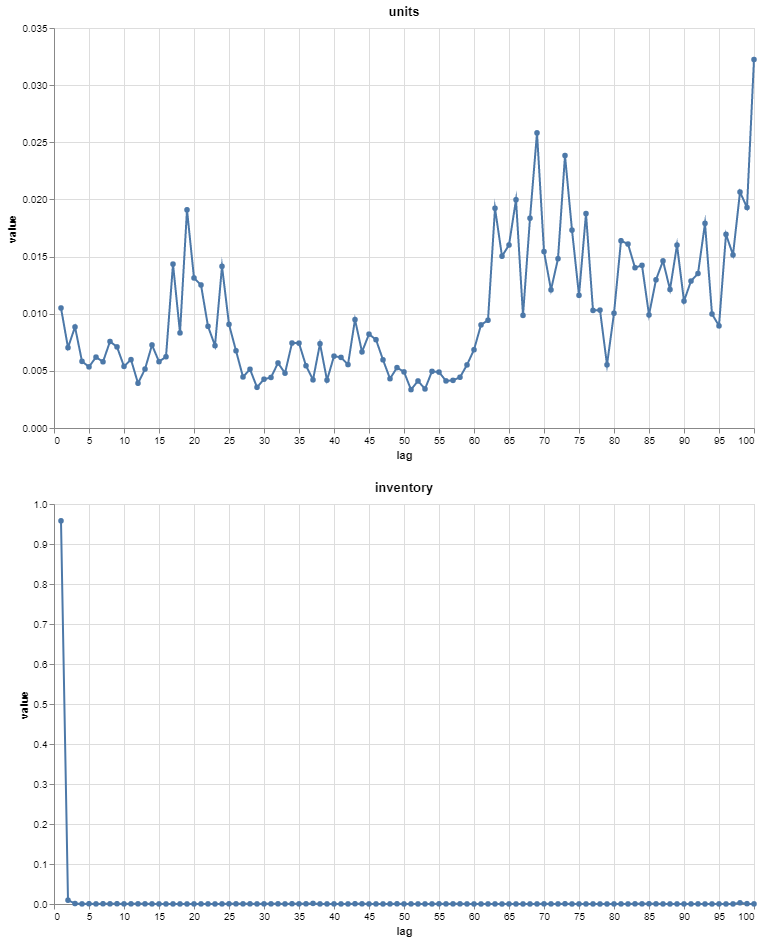

In [33]:
chart = alt.Chart(pd.melt(random_forest_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=name, height=400, width=700)
      for name in columns
    ],
    columns=1
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="independent", 
    y="independent"
)

In [30]:
n_lags = 100
pacf_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, get_pacf)
pacf_importances.head(3)

,lag,units,inventory
0,0,NaN,NaN
1,1,0.352215,0.979143
2,2,0.054017,0.001475


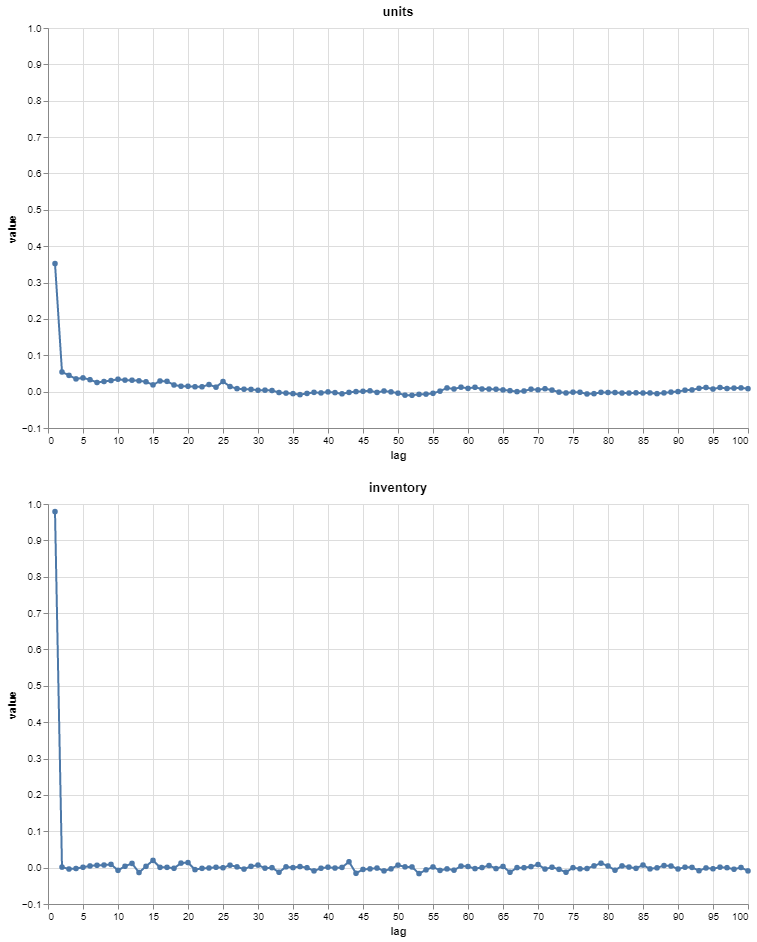

In [31]:
chart = alt.Chart(pd.melt(pacf_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=name, height=400, width=700)
      for name in columns
    ],
    columns=1
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="shared", 
    y="shared"
)

### Adspend investigation

In [31]:
columns = ["units", "adspend"]
use_zero_lag_list = [False, False]
independent_columns = [sales_df[column] for column in columns]
target_column = sales_df["adspend"]

In [32]:
n_lags = 100

random_forest_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, get_random_forest_importances)
random_forest_importances.head(3)

,lag,units,adspend
0,0,NaN,NaN
1,1,0.130084,0.671065
2,2,0.014556,0.011768


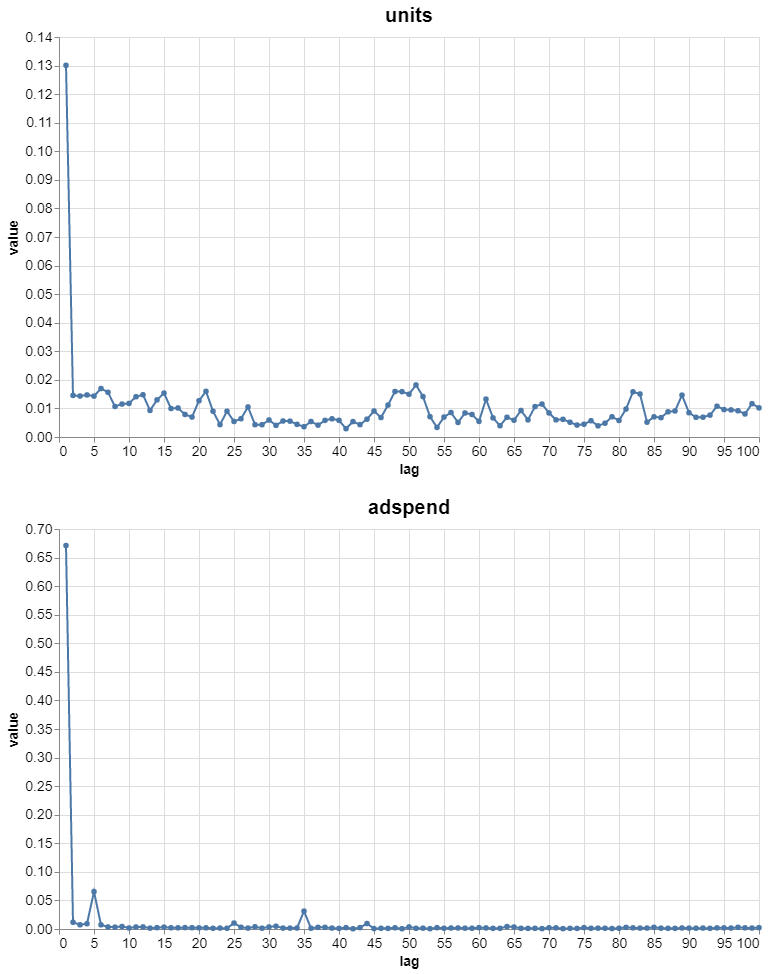

In [33]:
chart = alt.Chart(pd.melt(random_forest_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=name, height=400, width=700)
      for name in columns
    ],
    columns=1
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="independent", 
    y="independent"
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)

In [34]:
n_lags = 100
pacf_importances = get_feature_importance_df(independent_columns, use_zero_lag_list, target_column, n_lags, get_pacf)
pacf_importances.head(3)

,lag,units,adspend
0,0,NaN,NaN
1,1,0.142430,0.816332
2,2,-0.003859,0.041366


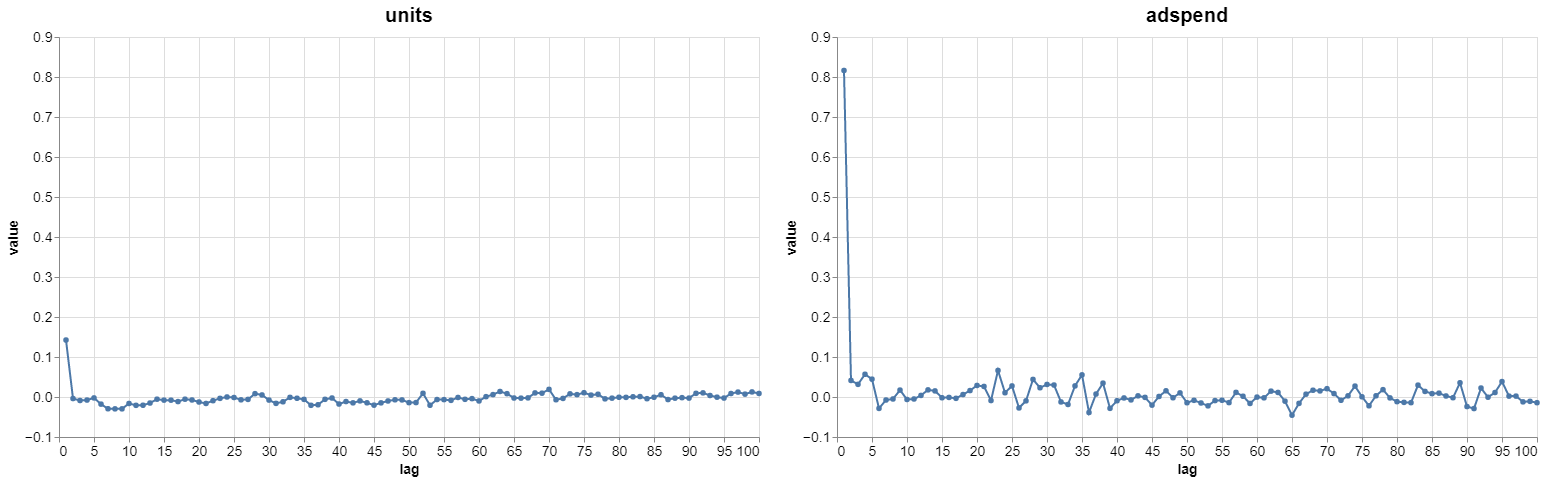

In [37]:
chart = alt.Chart(pd.melt(pacf_importances, "lag")).mark_line(point=True).encode(
    x=alt.X("lag:Q", scale=alt.Scale(zero=False)),
    y=alt.Y("value:Q", scale=alt.Scale(zero=False))
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.FieldEqualPredicate(field="variable", equal=name)) \
                  .properties(title=name, height=400, width=700)
      for name in columns
    ],
    columns=2
).resolve_axis(
    x="independent",
    y="independent"
).resolve_scale(
    x="shared",
    y="shared"
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(fontSize=20)